<a href="https://colab.research.google.com/github/russburns/Laframboise1966Code/blob/main/MAIN_PROGRAM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Code

In [ ]:
import numpy as np
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.optimize as opt

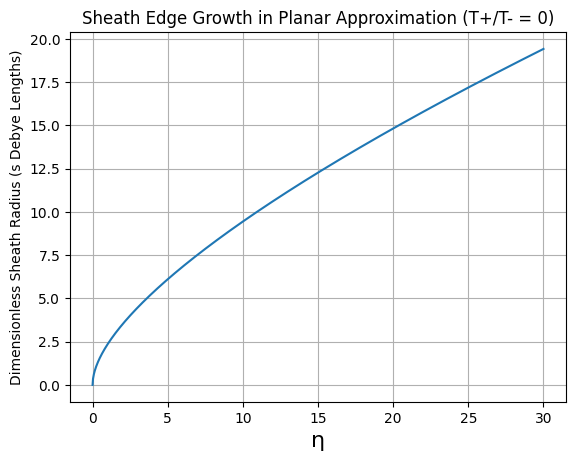

In [ ]:
VB = np.linspace(0, 30, 1000)
def coeft(x):
    result = (np.sqrt(np.pi) / 2) * special.erfcx(x) ##special function for exp(x**2) * erfcx(x), which is simply g(x) as defined in the paper
    return result

#eta function from Laframboise that acts on eta variavle
def eta(VB):
    return (1 / np.sqrt(np.pi)) * coeft(np.sqrt(VB))

#inner integral
def inner_integral(y_prime):
    result, _ = quad(eta, 0, y_prime)
    return result

#outer integral
def outer_integral(VB):
    def integrand(y_prime):
        inner = inner_integral(y_prime)
        if inner == 0:
            return 0
        return 1 / np.sqrt(2 * inner)

    result, _ = quad(integrand, 0, VB)
    return result

outer_integral_vectorized = np.vectorize(outer_integral)
s = outer_integral_vectorized(VB)

plt.plot(VB, s)
plt.xlabel("η",fontsize=16)
plt.ylabel("Dimensionless Sheath Radius (s Debye Lengths)")
plt.title("Sheath Edge Growth in Planar Approximation (T+/T- = 0)")
plt.grid()
plt.show()

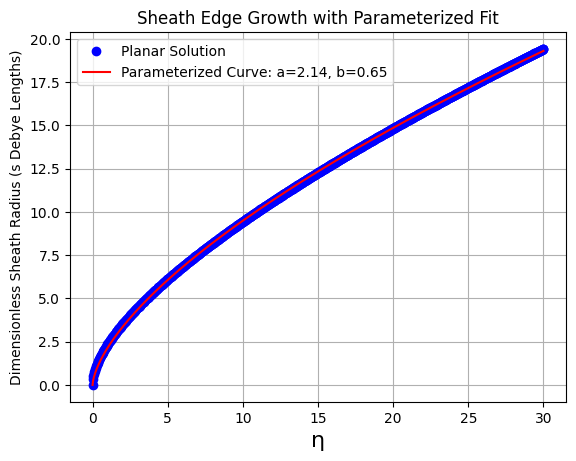

Fitted Parameters: [2.14486375 0.64617367]
R²: 0.9997656550847541


In [ ]:
#best form found
def fit_function2(y, a, b):
    return a*(y**b)

params, _ = opt.curve_fit(fit_function2, y, s)

s_fit = fit_function2(VB, *params)

plt.plot(VB, s, 'bo', label="Planar Solution")
plt.plot(VB, s_fit, 'r-', label=f"Parameterized Curve: a={params[0]:.2f}, b={params[1]:.2f}")
plt.xlabel("η",fontsize=16)
plt.ylabel("Dimensionless Sheath Radius (s Debye Lengths)")
plt.title("Sheath Edge Growth with Parameterized Fit")
plt.legend()
plt.grid()
plt.show()

print("Fitted Parameters:", params)

s_pred = fit_function2(VB, *params)

#R^2
ss_res = np.sum((s - s_pred) ** 2)
ss_tot = np.sum((s - np.mean(s)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print("R²:", r_squared)

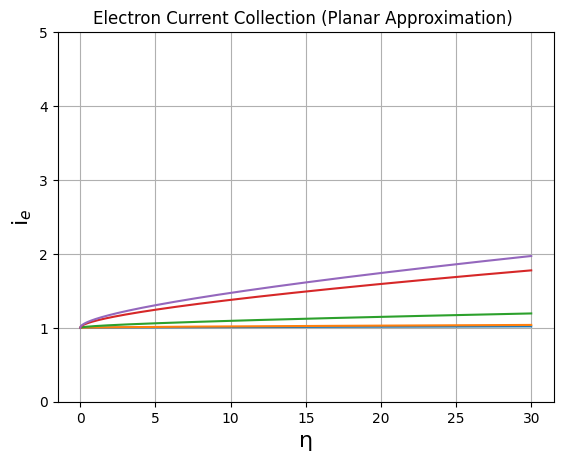

In [ ]:
#By F.18, i(VB) = 1 + (Debye_Length/Probe_Radius)*s(VB)
#In the planar approximation, (Debye_Length/Probe_Radius) = 0. Thus, we construct the first part of collected electron probe current for T+/T-=0. As described on Page 29, these currents are upper bounds.
#This collected current is understood to begin at the plasma potential.
Xi=np.array([1000, 500,100,25,20])
ratio = 1/Xi
current=[]
for i in range(len(Xi)):
  current.append(1 + ratio[i]*s)
  plt.plot(y, current[i])
plt.ylim(0, 5)
plt.xlabel("η",fontsize=16)
plt.ylabel("i$_e$", fontsize=16)
plt.title("Electron Current Collection (Planar Approximation) ")
plt.grid()
plt.show()

#Fortran II Code and Documentation

##MAIN PROGRAM 3

In [ ]:
        MAIN PROGRAM 3

C       SOLUTION OF Y DOUBLE PRIME = EXPF(Y)*(1.0-ERF(SQRT(Y)))/2.0
C                                  = COEFT(SQRTF(Y))/SQTPI

        DIMENSION ST(4001),X(501),Y(501),ETA(501),S(501),YP(4001)
    1       ETTA(4001),SS(4001),RPTRAP(4001)

    10  READ INPUT TAPE 5,11,YMAX,Y1,NX,KXPRIN,NYP,KYPRIN
    11  FORMAT(1P2E10.3,415)
        WRITE OUTPUT TAPE 6,12
    12  FORMAT(64H1 SOLUTION OF Y DOUBLE PRIME = EXPF(Y)*(1.0-ERF(SQRTF(
    1   Y)))/2.0)
        WRITE OUTPUT TAPE 6,13,YMAX,Y1,NX,KXPRIN,NYP,KYPRIN
    13  FORMAT(10H0      YMAX,8X2HY1,8X2HNX,4X6HKXPRIN,7X3HNYP,4XPHLYPRIN /
    1    1p2e10.3,4110  )

        SQTPI=1.7724539
        DELX=SQRTF(Y1)/FLOATF(NX)
        NXP=NX+1

        DO 15 I=1, NXP
        X(I)=DELX*FLOATF(I-1)
        XSQ=X(I)**2
        Y(I)=XSQ

        SUMA=1.0
        TERM=1.0
        DO 16 J=2,50
        TERM=TERM*XSQ/FLOATF(J)
        SAM=SUMA+TERM
        IF(SAM-SUMA)16,17,16
    16  SUMA = SAM

        WRITE OUTPUT TAPE 6,18
    18  FORMAT(10H NONCONV 1)
        GO TO 10

    17  TSQ=2.0*XSQ
        SUMB=0.66666667
        TERM=SUMBDO 20 K=2,50
        TERM=TERM*TSQ/FLOATF(2*K+1)
        SAM=SUMB+TERM
        IF(SAM-SUMB)20,23,23
    20  SUMB=SAM

        WRITE OUTPUT TAPE 6,24
    24  FORMAT(10H NONCONV 2)
        GO TO 10

    23  G=SUMA-2.0*X(I)*SUMB/SQTPI
        ST(I)=2.0/SQRTF(G)
    15  ETA(I)=COEFT(X(I)/SQTPI)

        S(1)=2.0
        S(2)=(5.0*ST(1)+8.0*ST(2)-ST(3))*DELX/12.0
        DO 25 I=3,NX
    25  S(I)=S(I-1)+(13.0*(ST(I-1)+ST(I))-ST(I-2)-ST(I+1))*DELX/24.0
        S(NXP)=S(NX)+(5.0*ST(NXP)+8.0*ST(NX)-ST(NX-1))*DELX/12.0

        DELY=(YMAX-Y1)/FLOATF(NYP)
        NYPP=NYP+1

        DO 30 I=1,NYPP
        YP(I)=Y1+DELY+FLOATF(I-1)
        SKY=SQRTF(YP(I))
        COE=COEFT(SKY)
        ETTA(I)=COE/SQTPI
        FT=(SKY+COE)*2.0/SQTPI-1.0
    30  ST(I)=1.0/SQRTF(FY)

        SS(1)=S(NXP)
        SS(2)=SS(1)+(5.0*ST(1)+8.0*ST(2)-ST(3))*DELY/12.0
        DO 32 I=3,NYP
    32  SS(I)=SS(I-1)+(13.0*(ST(I-1)+ST(I))-ST(I-2)-ST(I+1))*DELY/24.0
        SS(NYPP)=SS(NYP)+(5.0*ST(NYPP)+8.0*ST(NYP)-ST(NYP-1))*DELY/12.0

        DO 41 I=1,NYPP
    41  RPTRAP(I)=-2.0*YP(I)*ST(I)

        WRITE OUTPUT TAPE 6,40
    40  FORMAT(1H0,2(9X1HY,11X3HETA,13X1HS,12X),6X6HRPTRAP)
        I=1
        J=1
        ISTEP=NX/KXPRIN
        JSTEP=NYP/KYPRIN
        MAXP=XMAX0F(ISTEP,JSTEP)+1
        DO 36 K=1,MAXP
        WRITE OUTPUT TAPE 6,35,Y(I),ETA(I),YP(J),ETTA(J),SS(J),RPTRAP
    1   (J)
    35  FORMAT(1H,2(F11.5,F14.5,F14.5,11X),F12.4)
        I=I+KXPRIN
    36  J=J+KYPRIN
        GO TO 10
        END

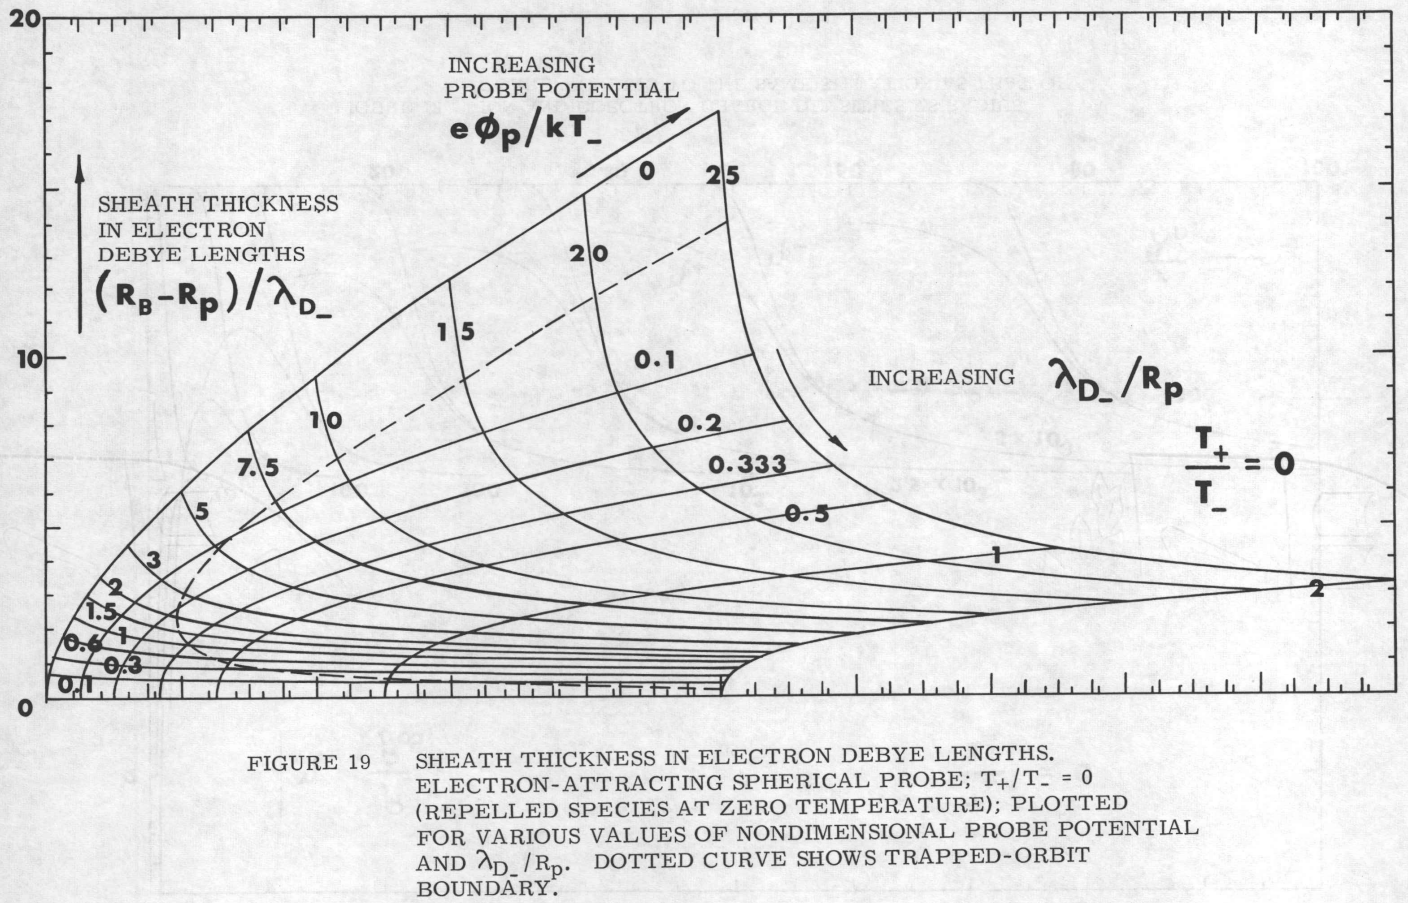

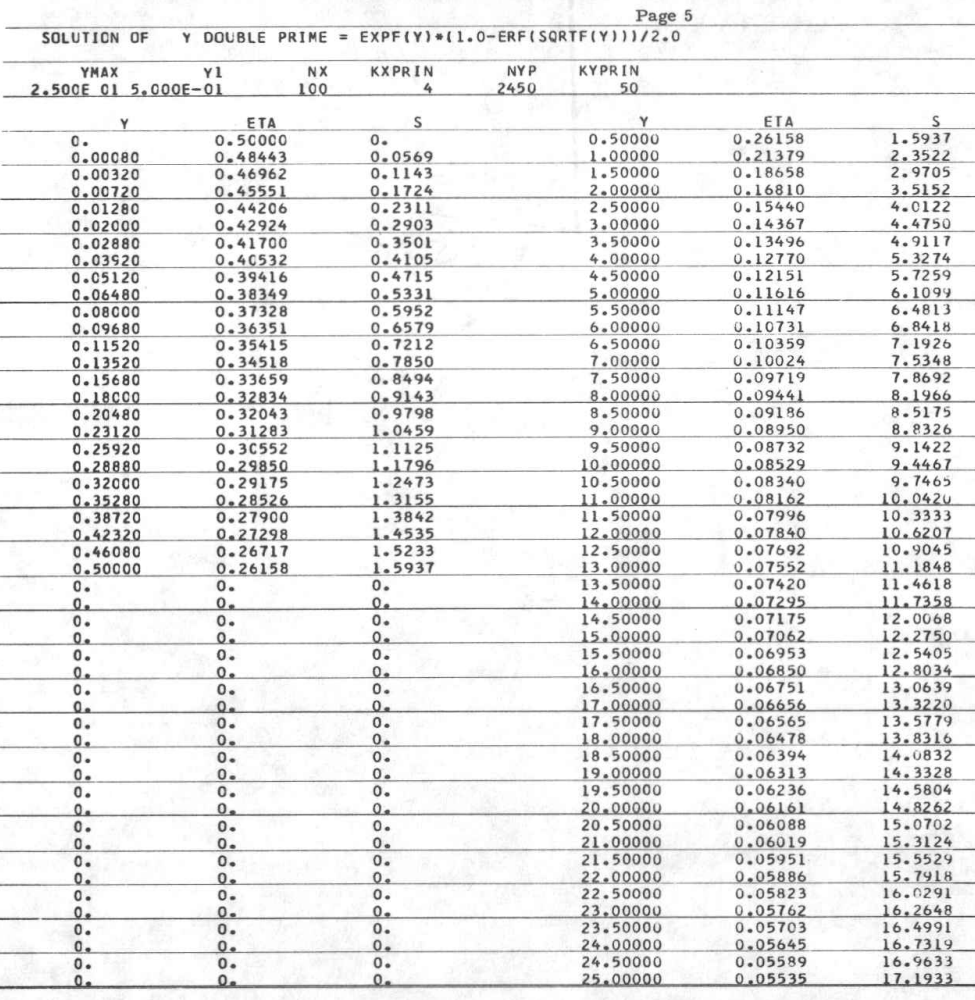

##COEFT

In [ ]:
        FUNCTION COEFT(EX)
C       COEFT(EX = 0.5 * ROOT OF PI * EXPF(EX*EX) * (1.0-ERF(EX))
C       ERF(EX) = 2.0/ROOT OF PI * INTEGRAL FROM 0 TO EX OF EXPF(-T*T)*DT
C       APPROXIMATION USED FOR ERF(EX) IS GIVEN ON PAGE 169 OF HASTINGS
C       (REF 17).

C       THIS SUBPROGRAM GIVES A RESULT WHICH HAS A REALTIVE ACCURACY OF
C       .00002 OR BETTER, DEPENDING ON THE ARGUMENT.
C       IF EX IS LESS THAN 2.21, HASTINF APPROXIMATION IS USED
C       OTHERWISE, ASYMPTOTIC SERIES IS USED.
C       IF EX IS BETWEEN 1.72 AND 2.82, A CORRECTION TERM IS ADDED

        DEX=EX
        IF(EX-1.72)9,9,11
    9   CORT = 0.0
        GO TO 15

    11  IF(EX-2.82)13,10,10
    10  SUM-0.5/EX
        TERM=SUM
        PROD=-2.0*EX**2
        DO 12 N=1,50
        TERMO=TERM
        TERM=TERM*FLOATF(2*N-1)/PROD
        IF(ABSF(TERM)-ABSF(TERMO))40,40,41
    40  SAM=SUM+TERM
        IF(SUM-SAM)12,16,12
    12  SUM=SAM
    41  SUM=SUM-0.5*TERMO
    16  COEFT=SUM
        RETURN

    13  IF(EX-2.21)20,21,21
    20  CORT=(EX-1.72)*(-.00000804-.00004920*EX-1.72))

    15  QA=1.0/(1.O+.3275911*EX)
    99  COEFT+CORT+((((.94064607*QA-1.2878225)*QA+1.2596951)*QA-.25212867)
    1   *QA+.22583685)*QA
        RETURN

    21  VIN=0.5/EX
        V=VIN/EX
        IF(EX-2.345)25,26,26
    25  CENT=472.5
        CORT=-.00001401+(EX-2.28)*(-.00030640+.00165700(EX-2.28))
        GO TO 30

    26  IF(EX-2.55)27,28,28
    27  CENT=945.-V*5197.5
        CORT=-.00000197+(EX-2.44)*(.00017400-.00087900*(EX-2.44))
        GO TO 30

    28  IF(EX-2.738)29,31,31
    29  CENT=945-.V*(10395.-V*67567.5)
        CORT=.00000040+(EX-2.64)*(-.00005370+.00029000*(EX-2.64))
        GO TO 30

    31  CENT=945.-V*(10395.-V*(135135.-V*1013512.5))
        CORT=0.000026630*(EX-2.82)
    30  COEFT=CORT+(((((-CENT*V+105.0)*V-15.0)*V+3.0)*V-1.0)*V+1.0)*VIN
        RETURN
        END

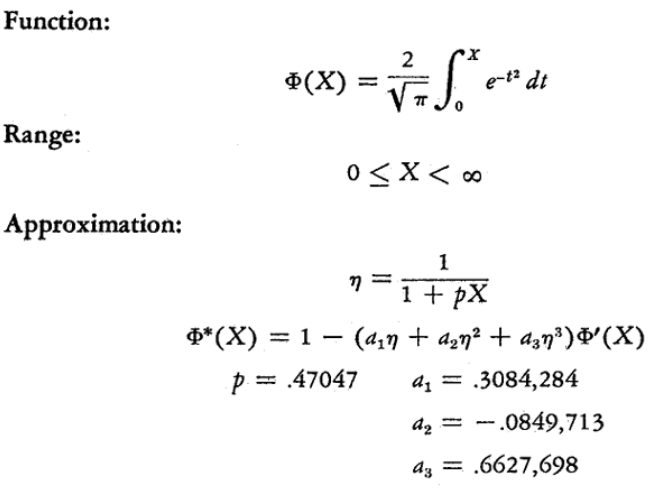

[Reference Link](https://blasingame.engr.tamu.edu/z_zCourse_Archive/P620_18C/P620_zReference/PDF_Txt_Hst_Apr_Cmp_(1955).pdf)